# CNN model using k-mer embeddings learned from human genome
 - Train Dataset = Human
 - Test Dataset = Human

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


In [2]:
input_hot_human = '../data/hot_lot_seqs/human/hot_regions_01_all.fa'
input_lot_human = '../data/hot_lot_seqs/human/lot_regions_01_all.fa'
input_hot_worm = '../data/hot_lot_seqs/worm/hot_region_01_all.fa'
input_lot_worm = '../data/hot_lot_seqs/worm/lot_region_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [3]:
with open(input_hot_human) as fasta_file:
    hot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_human.append(sequence)

with open(input_lot_human) as fasta_file:
    lot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_human.append(sequence)

with open(input_hot_worm) as fasta_file:
    hot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_worm.append(sequence)

with open(input_lot_worm) as fasta_file:
    lot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_worm.append(sequence)

### Create dataset for human and worm with two class label
The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [4]:
df_hot = pd.DataFrame(hot_sequences_human, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_human, columns=['sequence'])
df_lot['label'] = 0

human_data = pd.concat([df_hot, df_lot])
human_data.label.value_counts()

1    1504
0    1495
Name: label, dtype: int64

In [5]:
df_hot = pd.DataFrame(hot_sequences_worm, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_worm, columns=['sequence'])
df_lot['label'] = 0

worm_data = pd.concat([df_hot, df_lot])
worm_data.label.value_counts()

1    20139
0    18792
Name: label, dtype: int64

In [6]:
def seq2kmer_dataset(data, k, scaled= True):
    k = 4
    seq_kmers = []
    for df in range(len(data)):
        seq = data.iloc[df]['sequence']
        kmers = [seq[i:i+k].upper() for i in range(len(seq)-k+1)]
        kmers = ' '.join(kmers)
        seq_kmers.append(kmers)

    labels = data.loc[:,:]['label'].values

    c = CountVectorizer(ngram_range=(1,1))
    x = c.fit_transform(seq_kmers)
    scaler = MaxAbsScaler()
    x_scaled = scaler.fit_transform(normalize(x))
    df_kmer = pd.DataFrame(x.toarray(), columns=c.vocabulary_)
    df_kmer = df_kmer.reindex(sorted(df_kmer.columns), axis=1)

    df_kmer_scaled = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
    df_kmer_scaled = df_kmer_scaled.reindex(sorted(df_kmer_scaled.columns), axis=1)

    if scaled:
        return df_kmer_scaled, labels
    else:
        return df_kmer, labels


In [7]:
X, y = seq2kmer_dataset(human_data, 4, scaled=False)

In [8]:
X

,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,...,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
0,4,5,7,4,1,2,2,2,0,2,...,1,4,3,0,3,7,1,0,2,0
1,2,8,5,0,1,2,1,3,2,4,...,2,0,4,1,1,4,1,2,4,2
2,2,3,3,3,2,2,2,4,2,7,...,0,3,3,1,3,10,3,1,0,3
3,3,2,9,3,0,1,0,0,0,5,...,0,0,5,1,2,4,0,0,1,1
4,2,2,5,7,0,1,2,1,0,5,...,0,0,4,1,2,7,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,1,1,1,7,2,5,4,0,2,4,...,3,5,3,1,1,1,4,10,2,2
2995,5,1,1,5,6,20,12,0,2,2,...,9,5,5,0,9,3,2,18,3,7
2996,3,4,0,5,13,12,3,0,2,4,...,1,13,4,0,4,2,1,12,0,6
2997,3,2,0,3,2,7,3,0,6,2,...,4,6,2,1,3,1,1,3,0,1


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2999 samples in 0.001s...
[t-SNE] Computed neighbors for 2999 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2999
[t-SNE] Computed conditional probabilities for sample 2000 / 2999
[t-SNE] Computed conditional probabilities for sample 2999 / 2999
[t-SNE] Mean sigma: 10.669631
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.376633
[t-SNE] KL divergence after 1000 iterations: 1.973556


Text(0.5, 1.0, 't-SNE feature representation with 2 dimension')

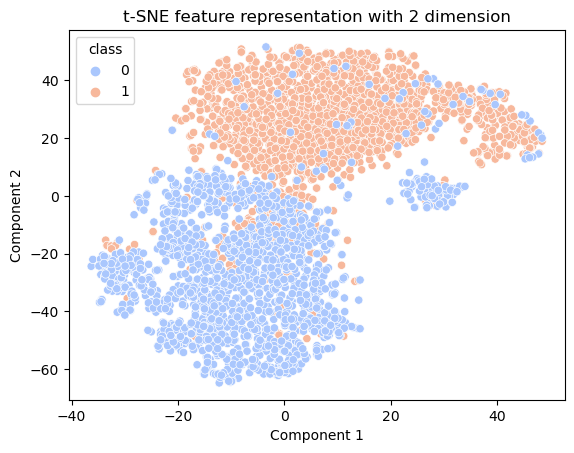

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
tsne_x = tsne.fit_transform(X) 

# create dataframe using the generated features
tsne_df = pd.DataFrame(data = tsne_x, columns = ['Com1', 'Com2'])
tsne_df['class'] = y

# Vizualize 
sns.scatterplot(data=tsne_df, x="Com1", y="Com2", hue="class", legend="full",palette="coolwarm")
plt.xlabel('Component 1', fontsize=10)
plt.ylabel('Component 2', fontsize=10)
plt.title("t-SNE feature representation with 2 dimension")

In [9]:
import csv
reader = csv.reader(open('../data/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.csv', 'r')) 
kmers_wv = {}
for row in reader:
    k = row[0]
    kmers_wv[k] = row[1:]
wvs = []
for kmer in X.columns:
    wvs.append(kmers_wv[kmer.upper()])
wvs = np.array(wvs, dtype=float)
wvs.shape

(256, 100)

In [13]:
X.shape

(2999, 256)

In [14]:
print(wvs)

[[ 0.015238  0.178107 -0.091419 ... -0.363131 -0.184487  0.187017]
 [-0.104339  0.224983 -0.034026 ...  0.283516 -0.506882  0.236254]
 [ 0.216324  0.264992 -0.388045 ...  0.013515 -0.020169 -0.068099]
 ...
 [-0.099851  0.223468  0.495296 ... -0.077472 -0.303269 -0.316688]
 [-0.14453   0.378944  0.136247 ... -0.037    -0.106457 -0.372506]
 [-0.06838   0.251549  0.194397 ... -0.075252 -0.266873 -0.528211]]


In [10]:
X_vec = []

for i in range(X.shape[0]):
    m2 = np.stack((X.iloc[i,:],) * wvs.shape[1], axis=1)
    vec_X = np.multiply(m2, wvs)
    X_vec.append(vec_X)

X_vec = np.array(X_vec)

In [11]:
print(X_vec.shape)

(2999, 256, 100)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state= 2,  stratify=y)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


(array([0, 1]), array([1121, 1128]))
(array([0, 1]), array([374, 376]))


## Train Model

Don't need to train when re-run. Best model is saved. 

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2022-12-09 00:36:42.752275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
inputs = keras.Input(shape= X_train.shape[1:], name="Input Sequence")

x_a = layers.Conv1D(filters = 120, kernel_size = 1, activation='relu')(inputs)
x_b = layers.Conv1D(filters = 120, kernel_size = 3, activation='relu')(inputs)
x_c = layers.Conv1D(filters = 120, kernel_size = 5, activation='relu')(inputs)
x_d = layers.Conv1D(filters = 120, kernel_size = 9, activation='relu')(inputs)
#x_e = layers.Conv1D(filters = 120, kernel_size = 15, activation='relu')(inputs)
#x_f = layers.Conv1D(filters = 120, kernel_size = 20, activation='relu')(inputs)

x_1 = layers.Concatenate(axis=1)([x_a, x_b, x_c, x_d])

x = layers.Flatten()(x_1)
#x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="hot_model")

2022-12-08 14:51:45.033311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.summary()

Model: "hot_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Sequence (InputLayer)    [(None, 256, 100)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 120)     12120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 254, 120)     36120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)              (None, 252, 120)     60120       ['Input Sequence[0][0]']         
                                                                                          

In [19]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.FalseNegatives()])

checkpoint = keras.callbacks.ModelCheckpoint(filepath='saved_models/human/my_best_model.epoch{epoch:02d}-acc{val_binary_accuracy:.2f}.hdf5', 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


In [20]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    verbose='auto',
    callbacks=[checkpoint],
    validation_split=0.20,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 26.9245 - binary_accuracy: 0.8627 - false_positives: 126.0000 - false_negatives: 121.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.94222, saving model to saved_models/human/my_best_model.epoch01-acc0.94.hdf5
57/57 [==============================] - 7s 113ms/step - loss: 26.9245 - binary_accuracy: 0.8627 - false_positives: 126.0000 - false_negatives: 121.0000 - val_loss: 0.1936 - val_binary_accuracy: 0.9422 - val_false_positives: 7.0000 - val_false_negatives: 19.0000
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.2376 - binary_accuracy: 0.9222 - false_positives: 57.0000 - false_negatives: 83.0000
Epoch 2: val_binary_accuracy did not improve from 0.94222
57/57 [==============================] - 6s 108ms/step - loss: 0.2376 - binary_accuracy: 0.9222 - false_positives: 57.0000 - false_negatives: 83.0000 - val_loss: 0.1939 - val_binary_accuracy: 0.9422 - val_false_positives: 8.0000 - val_f

24/24 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       374
           1       0.93      0.86      0.90       376

    accuracy                           0.90       750
   macro avg       0.90      0.90      0.90       750
weighted avg       0.90      0.90      0.90       750



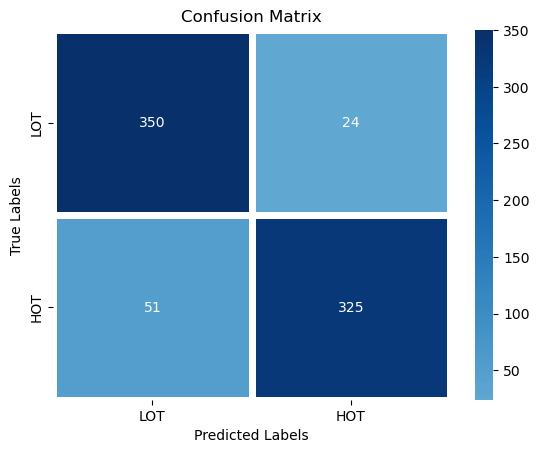

In [21]:
prob = model.predict(X_test)
y_pred = np.array([1 if p>0.5 else 0 for p in prob])
y_test, y_pred

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

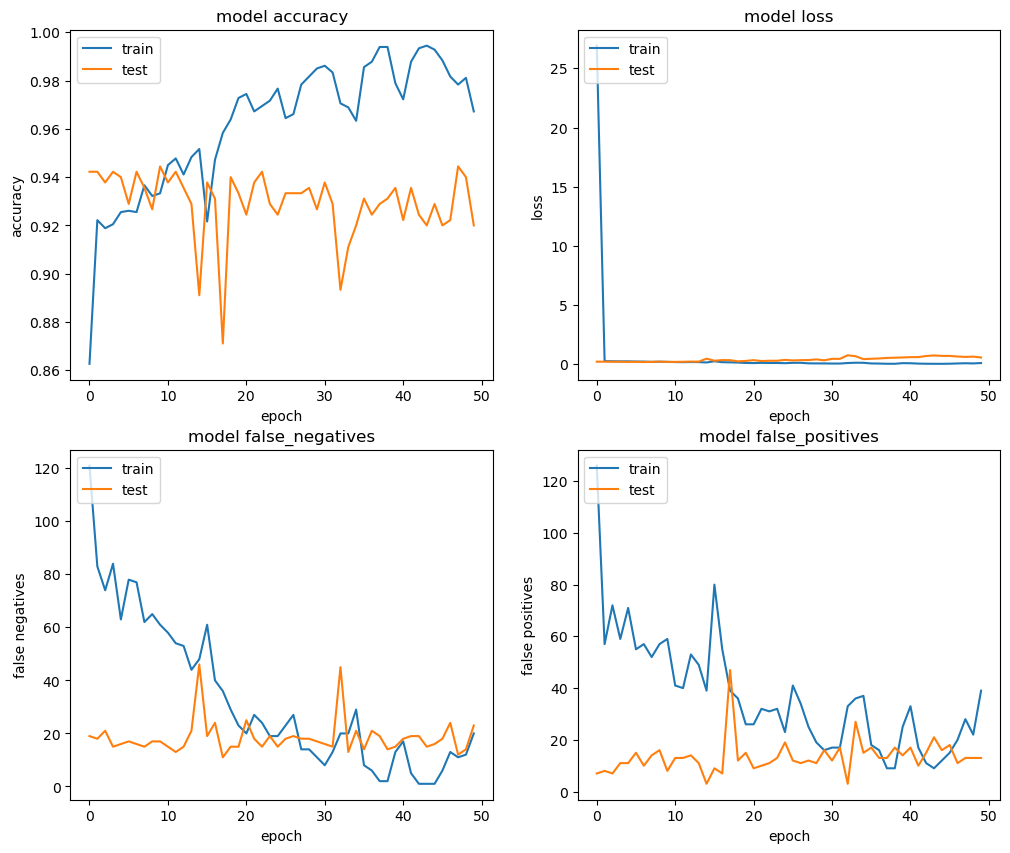

In [22]:
metrics = history.history.keys()
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history['false_negatives'])
plt.plot(history.history['val_false_negatives'])
plt.title('model false_negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history['false_positives'])
plt.plot(history.history['val_false_positives'])
plt.title('model false_positives')
plt.ylabel('false positives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load pretrained saved model

In [13]:
from keras.models import load_model
model = load_model('saved_models/human/my_best_model.epoch10-acc-0.94.hdf5')

2022-12-09 16:12:39.309079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 16:12:47.565999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
import shap
# select a set of background examples to take an expectation over
background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
#e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test)

# sh = np.array(shap_values).shape
# print(sh)
# A = np.reshape(shap_values[0], (sh[1],sh[2], sh[3],1))
# print(A.shape)
# # plot the feature attributions
# shap.image_plot(A, -X_test[:5])
# print(y_test[0:5])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [29]:
aa = np.array(shap_values[0])
# add the shap values in each dimention for each feature
aaa = np.array([np.sum(x, axis=1) for x in aa])

#Add all the SHAP values for each feature in each sample
rs = np.sum(aaa, axis=0)
rs.shape

(256,)

In [31]:
# sort the feature index based on their summed SHAP value
feature_idx = rs.argsort()

In [34]:
# top 20 features
X.columns[feature_idx[:20]]

Index(['tgat', 'gaat', 'ctat', 'gagt', 'gcac', 'gatg', 'tagg', 'gatc', 'catt',
       'tcta', 'tatc', 'ccat', 'tcca', 'ctag', 'aggt', 'cggt', 'ttaa', 'ctgt',
       'tcaa', 'cagg'],
      dtype='object')